In [ ]:
%pip install -U tqdm
%pip install -U scikit-learn
%pip install -U opencv-python
%pip install -U matplotlib
%pip install -U tensorflow

## **1 - Install Dependencies**

In [1]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import sklearn
from cv2 import imread
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

**NOTE: you can adjust these following parameters to generate/load data corresponding to them.** You have several options:

1) If you have already downloaded the raw data and extracted it to the /raw_data/ folder, you can regenerate data with new coloring/sizing options, but it may take a few minutes... Adjusting the parameters in the next cell will make those changes during regeneration. 

2) Otherwise, you can skip running any cells under section 2 and rely on the saved data formatted as a numpy array under /rgbZ/ or /grayscaleZ/ under /data/ to work with, where Z represents the image dimensions. Again, you can adjust the parameters in the next cell depending on which saved data you want to work with (assuming it exists).

In [2]:
grayscale = True
img_size = 64

## **2 - Generate Data** 
**NOTE: only run this to generate newly formatted data (for different color scheme or size)**. Otherwise this will be very slow for you. There already exists a saved numpy array of the data, so you can skip running cells under section 2. Otherwise consider batch loading.

In [ ]:
# The directory where the data is stored. Training and testing, respectively.
train_data = './raw_data/asl_alphabet_train/asl_alphabet_train/'
test_data = './raw_data/asl_alphabet_test/asl_alphabet_test/'

# Load the training data: see https://www.kaggle.com/code/shampasinha/interpret-sign-language-with-deep-learning 
# which was used as a reference for this function.
# The dataset is collosal, so we will use batch processing to load the data by default.
def load_train_data(data_dir, img_size=50, grayscale=False):
    images = []
    labels = []

    # Our data is structured in terms of folders. We iterate through each folder and read the images. 
    # Each folder represents a letter in the alphabet. 
    for folder in os.listdir(data_dir):
        for image in tqdm(os.listdir(data_dir + folder), desc=folder):

            # Read the image
            img = imread(data_dir + folder + '/' + image)
            
            # Convert the image to grayscale if needed
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Append the image and its corresponding label
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(str(folder))

            # Skip images that are not read correctly
            if img is None:
                continue
                
    # Convert the lists to numpy arrays. It is more efficient to work with numpy arrays...
    X = np.array(images)
    y = np.array(labels)

    # Normalize the images
    X = X.astype('float32') / 255.0
    return X, y

X, y = load_train_data(train_data, img_size=img_size, grayscale=grayscale)

In [ ]:
def save_data(X, y, grayscale=False, img_size=64):
    if grayscale:
        if not os.path.exists(f'./data/grayscale{img_size}'):
            os.makedirs(f'./data/grayscale{img_size}')
        X = np.save(f'./data/grayscale{img_size}/X.npy', X)
        y = np.save(f'./data/grayscale{img_size}/y.npy', y)
    else:
        if not os.path.exists(f'./data/rgb{img_size}'):
            os.makedirs(f'./data/rgb{img_size}')
        X = np.save(f'./data/rgb{img_size}/X.npy', X)
        y = np.save(f'./data/rgb{img_size}/y.npy', y)

save_data(X, y, grayscale=grayscale, img_size=img_size)

## **3 - Quick-Load, Batching, and Split**

In [3]:
def quick_load_data(grayscale=False, img_size=64):
    if grayscale:
        X = np.load(f'./data/grayscale{img_size}/X.npy')
        y = np.load(f'./data/grayscale{img_size}/y.npy')
    else:
        X = np.load(f'./data/rgb{img_size}/X.npy')
        y = np.load(f'./data/rgb{img_size}/y.npy')
    return X, y

X, y = quick_load_data(grayscale=grayscale, img_size=img_size)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [4]:
# We use batch sizes in the context of working with large datasets more efficiently.
batch_size = 32

In [5]:
# We create a dataset from the numpy arrays. Tensorflow allows us to use batching.
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# We shuffle the dataset and batch it. Buffer size exists for large datasets - especially ones that can't all fit memory.
# We shuffle also to prevent any biases in the data - each batch will be more representative of the data. Batching is used
# to make life easy and memory not overloaded. We can't possibly load all the data into memory at once.
train_data = train_data.shuffle(buffer_size=1024).batch(batch_size)
val_data = val_data.shuffle(buffer_size=1024).batch(batch_size)

## **4 - Inspect and Analyze**

Lets inspect that the image is correct.

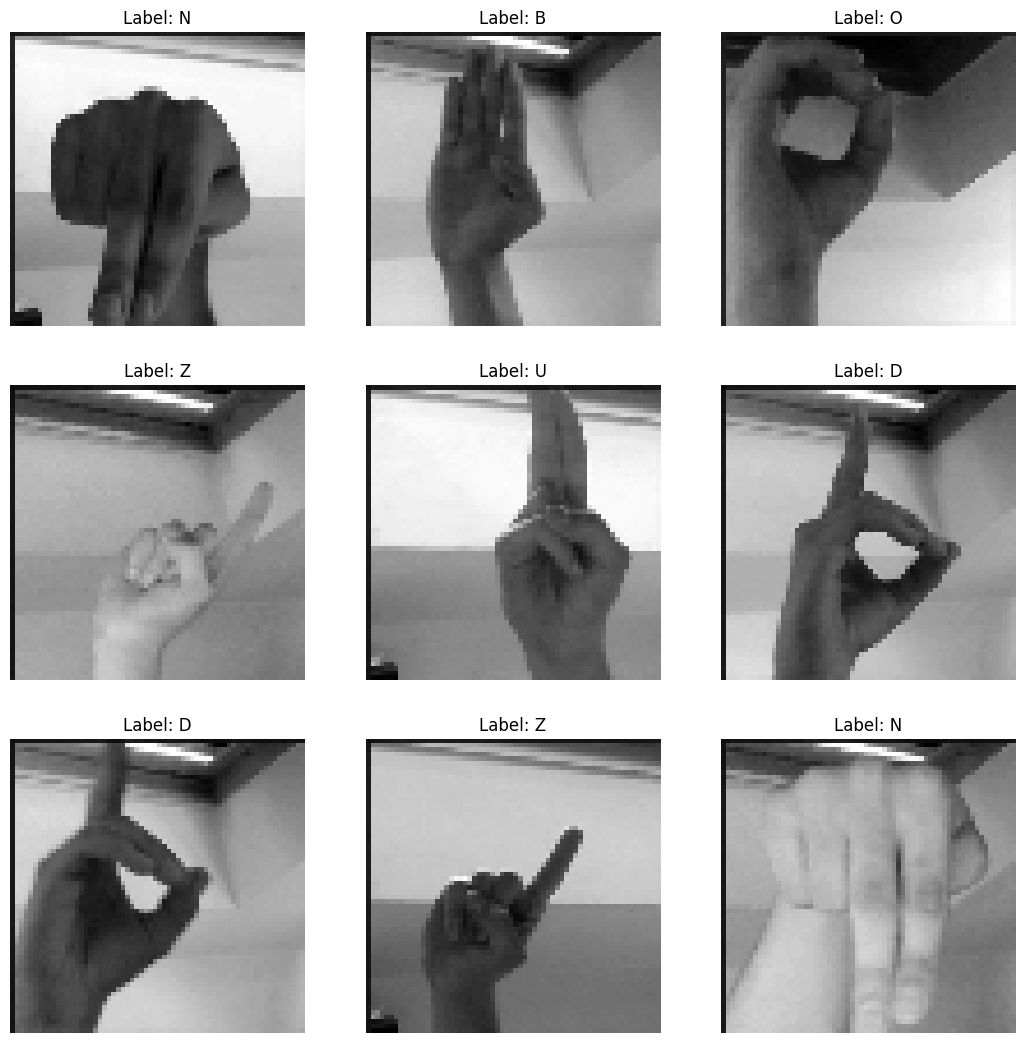

In [11]:
if grayscale:
    color = 'gray'
else:
    color = 'viridis'

# Plot the images and labels
random.seed(42)
indices = random.choices(range(len(X_val)), k=9)
n_row = 3
n_col = 3
fig, axes = plt.subplots(n_row, n_col, figsize=(13, 13))
for i in range(n_row):
    for j in range(n_col):
        axes[i, j].imshow(X_val[indices[i * n_col + j]], cmap=color)
        axes[i, j].set_title(f"Label: {y_val[indices[i * n_col + j]]}")
        axes[i, j].axis('off')
plt.show()

As we can see, the distribution of labels appears uniform (something that makes clear sense if you inspect raw_data). Relatively balanced!

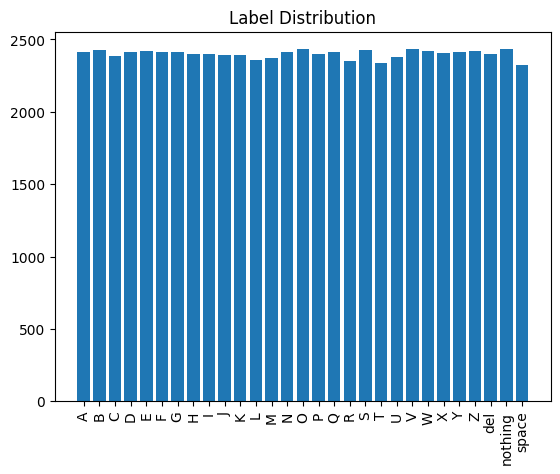

In [7]:
# Lets check how balanced the dataset is
unique_labels, label_counts = np.unique(y_train, return_counts=True)

plt.title('Label Distribution')
plt.bar(unique_labels, label_counts)
plt.xticks(rotation=90)
plt.show()

## **5 - First-Attempt Training**

In [ ]:
for batch, labels in train_data:
    pass

In [2]:
#TODO: T-SNE visualization of the data???
#TODO: color visualization of the data

ModuleNotFoundError: No module named 'tensorflow.keras.utils.PyDataset'